# Overview
This notebook applies some basic signal processing techniques to the bird sounds dataset for classification. 

## Extract
- Choose a cutoff minimum duration $s$. This will be the common duration for all the samples 
- Extract the signal and the sample rate for each sample
- For now just truncate to the middle $s$ seconds for each sample
- Resample to a common rate
- Save the signals and the labels to a dataset

## Transform
- Apply framing and windowing
- Apply the DTFT to produce the spectrogram
- Design a noise filter
- Normalize the spectrograms

## Train 
- Use a Tensorflow dataset to flow from the persisted dataset and apply the transformations
- Train a CNN model

# Imports

In [ ]:
import librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
import h5py
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
import math

In [ ]:
# Make sure GPU is available
tf.config.list_physical_devices('GPU')

# Exploratory Data Analysis
Here we will explore some basic properties of the dataset and choose a value for $s$ that makes sense based on the data.

In [4]:
metadata = pd.read_csv('/data/recordings.csv')
metadata.head()

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp,label
0,936105,Branta,bernicla,NaN,birds,Brant Goose,Arjun Dutta,United Kingdom,"Great Britain (near Wallington), Greater Lond...",51.3532,...,no,no,no,NaN,NaN,no,Tascam DR-05x,NaN,44100,goose
1,934302,Branta,bernicla,NaN,birds,Brant Goose,Mats Olsson,Sweden,"Dalgången 23, Karlshamn, Blekinge län",NaN,...,no,no,no,NaN,NaN,no,Wildlife Acoustics,NaN,24000,goose
2,906056,Branta,bernicla,NaN,birds,Brant Goose,Juha Saari,Finland,"Pihlajamäki, Helsinki, Uusimaa",60.2357,...,no,no,no,NaN,NaN,yes,NaN,Telinga PRO-X,44100,goose
3,898133,Branta,bernicla,NaN,birds,Brant Goose,Paul Kelly,Ireland,"Tacumshin Lake (East End), County Wexford",52.1963,...,no,no,no,NaN,NaN,yes,SM4,SM4,44100,goose
4,882013,Branta,bernicla,NaN,birds,Brant Goose,Jean COURTIN,France,"Arrondissement de Vannes (near Sérent), Morbi...",47.7981,...,yes,yes,no,NaN,NaN,yes,NaN,NaN,44100,goose


In [5]:
# Extract timestamps
metadata['length'] = metadata['length'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# Create dictionary of id to label
label_dict = dict(zip(metadata['id'], metadata['label']))

In [6]:
metadata['length'].describe()

count    7006.000000
mean       42.353697
std        84.070134
min         0.000000
25%        10.000000
50%        21.000000
75%        45.000000
max      1800.000000
Name: length, dtype: float64

In [7]:
metadata[metadata['length'] > 10]['label'].value_counts()

label
hawk     2044
heron    1664
goose    1455
Name: count, dtype: int64

In [8]:
def plot_signal(signal, fs, title):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signal, sr=fs)
    plt.title(title)

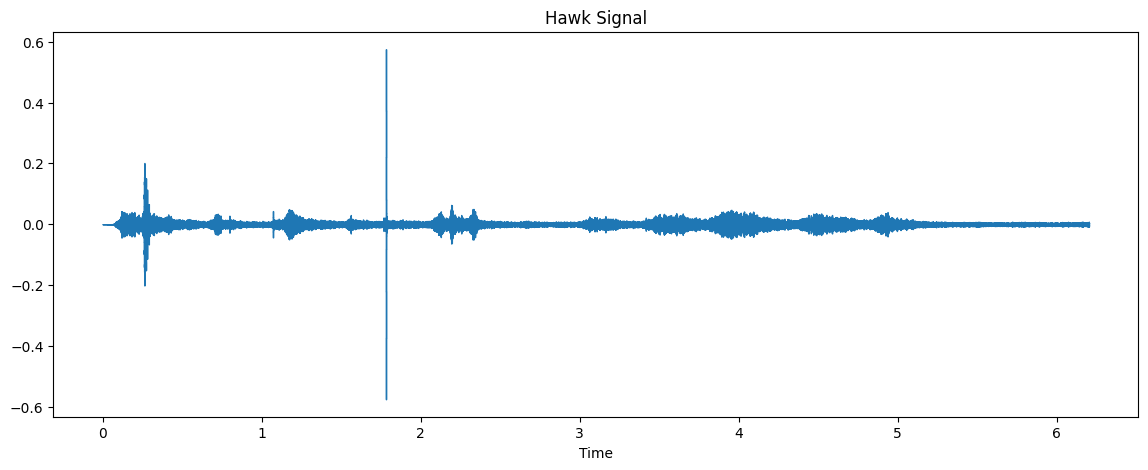

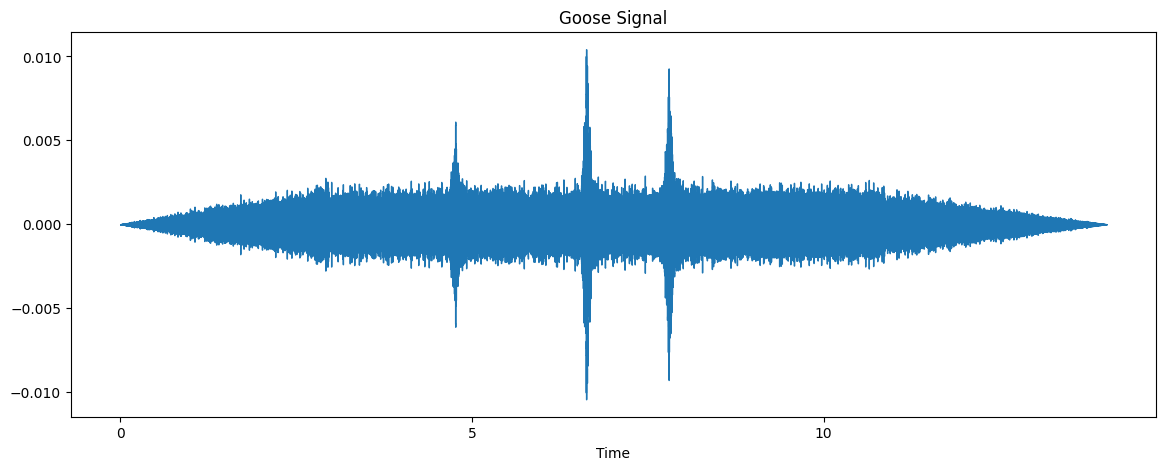

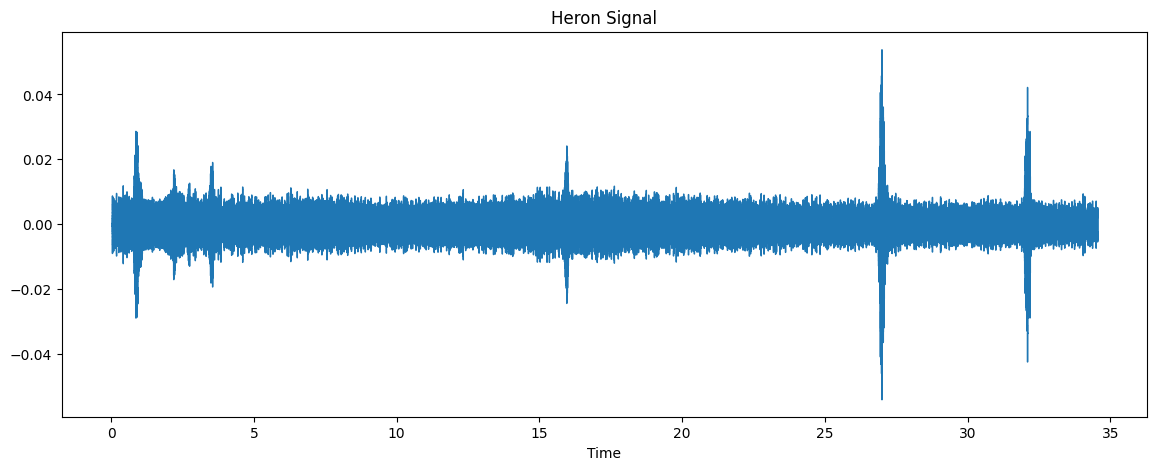

In [9]:
# Load signal and sample rate
hawk_signal, hawk_fs = librosa.load('/data/hawk_211230.mp3', sr=None)
goose_signal, goose_fs = librosa.load('/data/goose_678800.mp3', sr=None)
heron_signal, heron_fs = librosa.load('/data/heron_268502.mp3', sr=None)

# Plot signal
plot_signal(hawk_signal, hawk_fs, 'Hawk Signal')
plot_signal(goose_signal, goose_fs, 'Goose Signal')
plot_signal(heron_signal, heron_fs, 'Heron Signal')

# Extract
Here we will:
- Load the data using `librosa`
- Truncate to extract the middle $s$ seconds
- Resample to a common sample rate
- Save the signals and labels to a file

In [10]:
def extract_middle(signal, fs, duration_seconds=10):
    duration_samples = duration_seconds * fs
    signal_length = len(signal)
    start = (signal_length - duration_samples) // 2
    end = start + duration_samples
    return signal[start:end]

def load_batch(batch, duration_seconds=10, target_fs=16000):
    signals = []
    labels = []
    ids = []
    for i, file in enumerate(batch):
        # Check that file exists
        if not os.path.exists(f'/data/{file}'):
            print(f'Skipping {file} due to missing file')
            continue
        signal, fs = librosa.load(f'/data/{file}', sr=None)
        signal = extract_middle(signal, fs, duration_seconds)
        if len(signal) != duration_seconds * fs:
            print(f'Skipping {file} due to incorrect duration')
            continue
        signal = librosa.resample(signal, orig_sr=fs, target_sr=target_fs)
        signals.append(signal)
        file_name = file.split('_')
        labels.append(file_name[0])
        ids.append(int(file_name[1].split('.')[0]))
    return np.array(signals), np.array(ids), np.array(labels)

def save_batch(batch, save_path, dataset_name='signals'):
    with h5py.File(save_path, 'a') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            dataset.resize(dataset.shape[0] + batch.shape[0], axis=0)
            dataset[-batch.shape[0]:] = batch
        else:
            maxshape = (None,) + batch.shape[1:]
            f.create_dataset(dataset_name, data=batch, maxshape=maxshape, chunks=True)

def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

def extract_signals(file_list, save_path, ohe, duration_seconds=10, batch_size=32, target_fs=16000):
    for i, batch_files in enumerate(get_batches(file_list, batch_size)):
        signals, ids, labels = load_batch(batch_files, duration_seconds, target_fs)
        labels = ohe.transform(labels.reshape(-1, 1)).toarray()
        save_batch(signals, save_path, 'signals')
        save_batch(labels, save_path, 'labels')
        save_batch(ids, save_path, 'ids')
        print(f'Saved {len(batch_files)} signals for batch {i}')

In [11]:
metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)
files = metadata[metadata['length'] > 10]['file_path'].values
len(files)

/tmp/ipykernel_42701/2003793498.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)


5163

In [ ]:
ohe = OneHotEncoder().fit(np.array(['hawk', 'heron', 'goose']).reshape(-1, 1))
# extract_signals(files, '/data/bird_sounds.h5', ohe, duration_seconds=10, batch_size=64, target_fs=16000)

## Transform
Here we will build a TensorFlow dataset that reads from the saved file in batches and applies the following transformations:
- Framing
- Windowing (using a Hamming function)
- FFT (real-valued) to produce the spectrogram
- Take the log magnitude of the spectrum
- Normalize

In [13]:
def load_dataset(file_path, dataset_name):
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name]
        for i in range(len(data)):
            yield data[i]

In [14]:
signal_it = load_dataset('/data/bird_sounds.h5', 'signals')
signal = next(signal_it)

In [15]:
frame_size = 1024
frame_step = 512 # 50% overlap
frames = tf.signal.frame([signal], frame_length=frame_size, frame_step=frame_step)
window = tf.signal.hamming_window(frame_size)
windowed_frames = frames * window
spectrogram = tf.abs(tf.signal.rfft(windowed_frames))
log_spectrogram = tf.math.log(spectrogram)

I0000 00:00:1732068405.158776   42701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 57 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:25:00.0, compute capability: 6.1


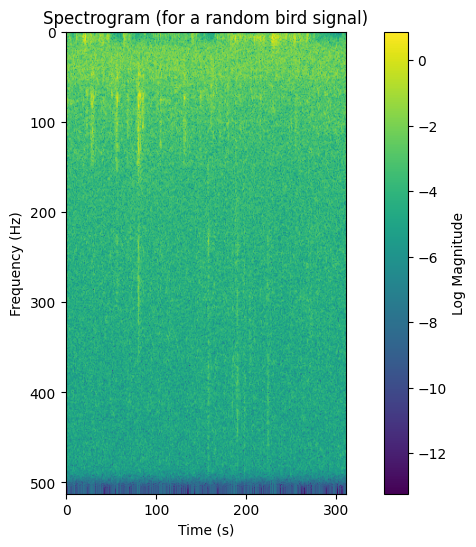

In [16]:
plt.figure(figsize=(10, 6))
plt.imshow(tf.transpose(log_spectrogram))
plt.colorbar(label='Log Magnitude')
plt.title("Spectrogram (for a random bird signal)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [17]:
def build_signal_dataset(filepath, batch_size, sample_rate = 16000, duration_seconds = 10, frame_size = 1024, step_size = 512):
    signal_dataset = tf.data.Dataset.from_generator(
        lambda: load_dataset(filepath, 'signals'),
        output_signature=tf.TensorSpec(shape=(sample_rate * duration_seconds,), dtype=tf.float32)
    )

    label_dataset = tf.data.Dataset.from_generator(
        lambda: load_dataset(filepath, 'labels'),
        output_signature=tf.TensorSpec(shape=(3,), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.zip((signal_dataset, label_dataset))

    window = tf.signal.hamming_window(frame_size)
    
    # Framing
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.frame(signals, frame_size, step_size, axis=0), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Windowing
    dataset = dataset.map(
        lambda signals, labels: (signals * window, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Real-valued Fourier Transform
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.rfft(signals), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Log-magnitude
    dataset = dataset.map(
        lambda signals, labels: (tf.math.log(tf.abs(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Normalization
    dataset = dataset.map(
        lambda signals, labels: (tf.math.divide(signals, tf.reduce_max(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
def compute_input_size(sample_rate, duration_seconds, frame_size, step_size):
    signal_length = sample_rate * duration_seconds
    
    # Compute the number of frames
    num_frames = math.floor((signal_length - frame_size) / step_size) + 1
    
    # Compute the number of frequency bins
    frequency_bins = frame_size // 2 + 1
    
    return num_frames, frequency_bins

In [19]:
dataset = build_signal_dataset('/data/bird_sounds.h5', 32, duration_seconds=10, frame_size=1024, step_size=512)

# Train
Finally, build a CNN model to train on the normalized log spectrograms from the dataset.

In [20]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model

In [21]:
sample_rate = 16000
duration_seconds = 10
frame_size = 1024
step_size = 512

In [ ]:
dataset = build_signal_dataset('/data/bird_sounds.h5', 32, duration_seconds=duration_seconds, frame_size=frame_size, step_size=step_size)
num_frames, frequency_bins = compute_input_size(sample_rate, duration_seconds, frame_size, step_size)
model = build_model((num_frames, frequency_bins, 1), 3)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 311, 513, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 155, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 155, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 155, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 77, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 77, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 77, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 311296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    39,846,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,819,019 (457.07 MB)

 Trainable params: 39,939,523 (152.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 79,879,048 (304.71 MB)

In [ ]:
model.fit(dataset, epochs=10)